In [38]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

/var/folders/4m/rxd9grt91hq7n4__bqp6nkvr0000gn/T/ipykernel_16147/1659410565.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [39]:
# df_ori = pd.read_csv('./close.csv', sep=',')
df_ori = pd.read_csv('./close_390.csv', sep=',')
df_ori.head()

,Date,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
0,2003-11-18 00:00:00,19.864092,0.364464,19.787552,4.156667,24.120001,20.049999,44.889999,14.22,29.874723,...,87.735100,56.070000,20.15,15.960000,35.150002,21.270000,11.905104,61.902912,39.433334,61.590000
1,2003-11-19 00:00:00,19.814020,0.364643,19.913242,4.194444,24.049999,19.799999,46.590000,14.24,30.104713,...,87.682121,56.150002,20.18,16.309999,35.439999,21.209999,11.772106,61.757282,40.133331,61.049999
2,2003-11-20 00:00:00,19.484980,0.363929,19.545143,4.085556,24.219999,19.150000,45.810001,14.32,29.462332,...,87.841057,56.009998,21.50,16.260000,35.310001,21.320000,11.718188,61.815533,40.053333,60.970001
3,2003-11-21 00:00:00,19.449213,0.362143,19.603500,4.080000,24.160000,19.680000,47.180000,14.13,29.390955,...,87.390732,56.480000,21.50,16.260000,35.340000,21.540001,11.693027,61.660194,40.093334,60.750000
4,2003-11-24 00:00:00,19.814020,0.377679,20.012001,4.066667,24.860001,20.700001,48.779999,14.34,29.898516,...,87.284767,56.450001,21.57,16.520000,35.560001,22.000000,12.095615,63.446602,41.759998,60.549999


In [40]:
df_ori.set_index('Date', inplace=True)
df_ori.index = pd.DatetimeIndex(df_ori.index)
# df.head()

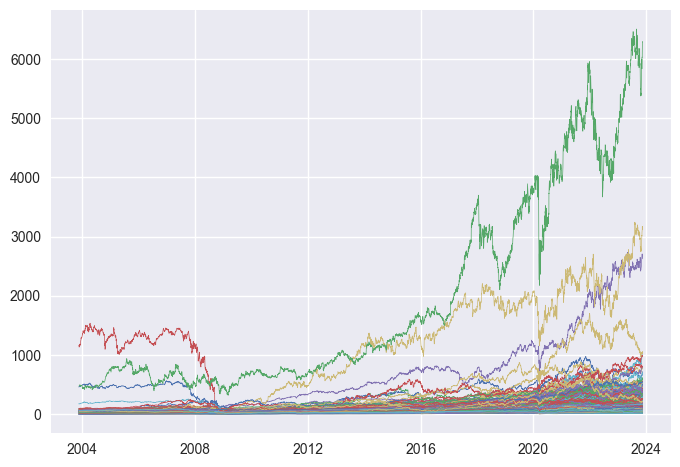

In [41]:
plt.figure()
for stk in df_ori.columns:
    plt.plot(df_ori.index, df_ori.loc[:,stk], linewidth=0.5, label=stk)
    # plt.legend(loc='best')

plt.show()

In [42]:
df = df_ori.pct_change().iloc[1:,:]
df.head()

/var/folders/4m/rxd9grt91hq7n4__bqp6nkvr0000gn/T/ipykernel_16147/1319754349.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df = df_ori.pct_change().iloc[1:,:]


,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2003-11-19,-0.002521,0.000491,0.006352,0.009088,-0.002902,-0.012469,0.037870,0.001406,0.007698,-0.010709,...,-0.000604,0.001427,0.001489,0.021930,0.008250,-0.002821,-0.011171,-0.002353,0.017751,-0.008768
2003-11-20,-0.016606,-0.001958,-0.018485,-0.025960,0.007069,-0.032828,-0.016742,0.005618,-0.021338,0.000000,...,0.001813,-0.002493,0.065411,-0.003066,-0.003668,0.005186,-0.004580,0.000943,-0.001993,-0.001310
2003-11-21,-0.001836,-0.004908,0.002986,-0.001360,-0.002477,0.027676,0.029906,-0.013268,-0.002423,0.161340,...,-0.005127,0.008391,0.000000,0.000000,0.000850,0.010319,-0.002147,-0.002513,0.000999,-0.003608
2003-11-24,0.018757,0.042900,0.020838,-0.003268,0.028974,0.051829,0.033913,0.014862,0.017269,0.016866,...,-0.001213,-0.000531,0.003256,0.015990,0.006225,0.021356,0.034430,0.028972,0.041570,-0.003292
2003-11-25,0.002888,-0.022223,-0.002692,0.006011,-0.016090,-0.008937,0.006560,-0.013947,-0.005570,0.012658,...,-0.004552,0.003366,0.089476,0.009685,0.007312,0.020455,0.006538,-0.004132,-0.013250,0.007267


In [43]:
df = df.dropna(axis=1)
df.isnull().sum().sum()

0

In [44]:
df.head()

,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2003-11-19,-0.002521,0.000491,0.006352,0.009088,-0.002902,-0.012469,0.037870,0.001406,0.007698,-0.010709,...,-0.000604,0.001427,0.001489,0.021930,0.008250,-0.002821,-0.011171,-0.002353,0.017751,-0.008768
2003-11-20,-0.016606,-0.001958,-0.018485,-0.025960,0.007069,-0.032828,-0.016742,0.005618,-0.021338,0.000000,...,0.001813,-0.002493,0.065411,-0.003066,-0.003668,0.005186,-0.004580,0.000943,-0.001993,-0.001310
2003-11-21,-0.001836,-0.004908,0.002986,-0.001360,-0.002477,0.027676,0.029906,-0.013268,-0.002423,0.161340,...,-0.005127,0.008391,0.000000,0.000000,0.000850,0.010319,-0.002147,-0.002513,0.000999,-0.003608
2003-11-24,0.018757,0.042900,0.020838,-0.003268,0.028974,0.051829,0.033913,0.014862,0.017269,0.016866,...,-0.001213,-0.000531,0.003256,0.015990,0.006225,0.021356,0.034430,0.028972,0.041570,-0.003292
2003-11-25,0.002888,-0.022223,-0.002692,0.006011,-0.016090,-0.008937,0.006560,-0.013947,-0.005570,0.012658,...,-0.004552,0.003366,0.089476,0.009685,0.007312,0.020455,0.006538,-0.004132,-0.013250,0.007267


In [45]:
def equally_weighted(df):
    arr_pfl = [1]
    cur_pfl = 1
    cur_stg = np.array([1 / len(df.columns)] * len(df.columns))
    # print(cur_stg)

    for i in range(len(df)):
        cur_pfl = cur_pfl * np.dot(cur_stg, 1 + df.iloc[i,:].values)
        arr_pfl.append(cur_pfl)

    return arr_pfl

arr_equal = equally_weighted(df)

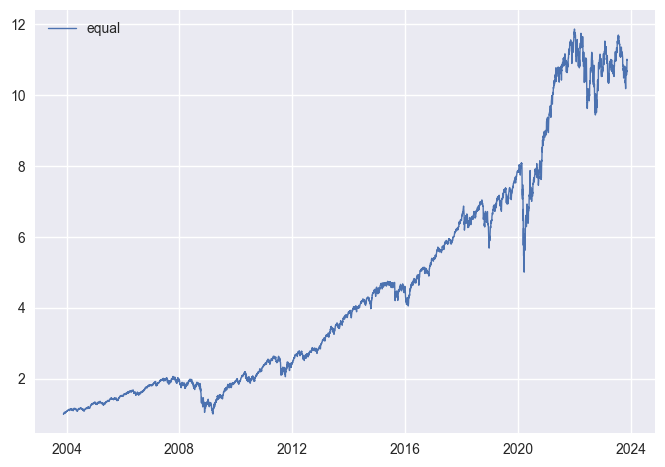

In [46]:
plt.figure()
# plt.plot(df.index, arr_pfl[:-1], linewidth=0.5, label='OGD')
plt.plot(df.index, arr_equal[:-1], linewidth=1, label='equal')
plt.legend(loc='best')
plt.show()

In [53]:
# begin OGD process
def OGD_update(x_old, ETA, loss, num_of_var):
    x = cp.Variable(num_of_var, nonneg=True)
    # x = cp.Variable(num_of_var, nonneg=False)
    objective = cp.Minimize(ETA * np.array(loss) @ x + 0.5 * cp.sum((x - x_old) ** 2))
    constraints = [cp.sum(x) == 1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver=cp.ECOS)

    return x.value

def OGD_algo(df, ETA):
    arr_pfl = [1]
    cur_pfl = 1
    cur_stg = np.array([1/len(df.columns)] * len(df.columns))
    arr_stg = [cur_stg]

    for i in tqdm(range(len(df))):
        # return of today
        cur_pfl = cur_pfl * np.dot(cur_stg, 1 + df.iloc[i,:].values)
        arr_pfl.append(cur_pfl)
        # define the loss
        loss = -1 * df.iloc[i,:].values
        # OGD to find strategy in the next round
        cur_stg = OGD_update(cur_stg, ETA, loss, len(df.columns))
        arr_stg.append(cur_stg)

    return arr_pfl , arr_stg

ETA = 0.05
arr_pfl , arr_stg = OGD_algo(df, ETA)

100%|██████████| 5034/5034 [00:59<00:00, 84.55it/s]


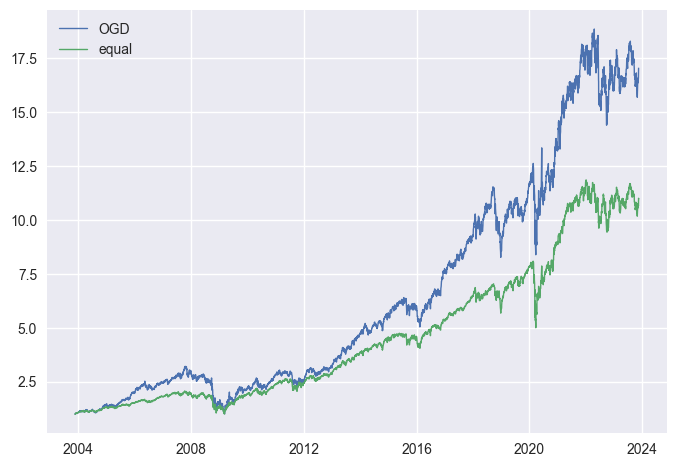

In [54]:
plt.figure()
plt.plot(df.index, arr_pfl[:-1], linewidth=1, label='OGD')
plt.plot(df.index, arr_equal[:-1], linewidth=1, label='equal')
plt.legend(loc='best')
plt.show()

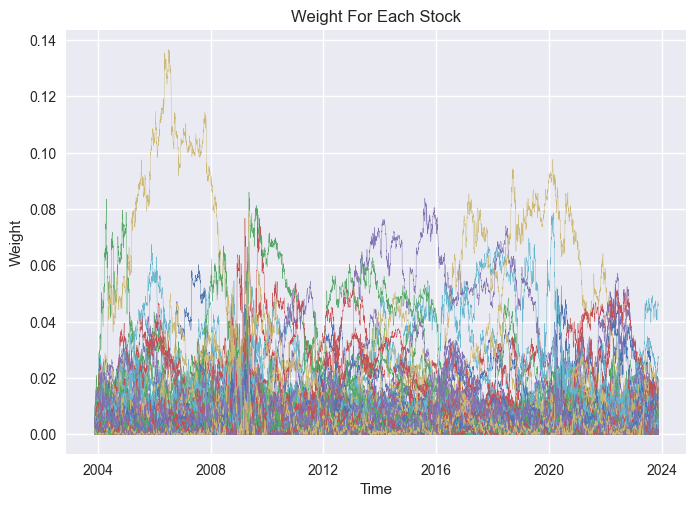

In [55]:
arr_stg = pd.DataFrame(arr_stg, columns=df.columns)

plt.figure()
for stk in arr_stg.columns:
    plt.plot(df.index, arr_stg.loc[:,stk][:-1], linewidth=0.3)

plt.xlabel('Time')
plt.ylabel('Weight')
plt.title('Weight For Each Stock')
plt.show()